<a href="https://colab.research.google.com/github/Dom-DJ/Animender/blob/main/anime_recommender_model_analysis_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports and packages

this is an anime recommender model. It looks at the anime you have previously finished and uses that as a sign that you liked them. Next it predicts one you may like based on that.

In [8]:
import numpy as np # linear algebra
import json
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import pathlib
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

Not all of these are used but were utilised in previous versions and therefore I have kept them

# getting the data

In [9]:
animecsv = pd.read_csv("./anime.csv")
ratingcsv = pd.read_csv("./rating_complete.csv")

* animecsv is used to filter animes by popularity and for data analysis.
* ratingcsv is used to get what animes people have watched for training.

In [10]:
ids = []

for i in range(len(animecsv["MAL_ID"])):
    if animecsv["Popularity"][i] < 1000 and animecsv["Popularity"][i] > 0:
        ids.append(animecsv["MAL_ID"][i])

I only want the most popular through to the 1000th most popular. This is to minimise paramaters that would otherwise be much larger and also to avoid anomalies if the algorithm doesnt properly understand the anime due to a lack of samples

In [11]:
id_to_num = {}

for i in range(len(ids)):
    id_to_num[ids[i]] = i
    
    
l=0
for i in id_to_num:
    print(str(i) + ":" + str(id_to_num[i]))
    l+=1
    if l == 5:
        break
        
with open('data.txt', 'w') as outfile: # used in web app
    data = {}
    for i in id_to_num:
        for j in range(len(animecsv["MAL_ID"])):
            if animecsv["MAL_ID"][j] == i:
                if animecsv["English name"][j] != "Unknown":
                    if animecsv["English name"][j] in data.keys():
                        data[str(i)] = id_to_num[i]
                    else:
                        data[animecsv["English name"][j]] = id_to_num[i]
                else:
                    if animecsv["Name"][j] in data.keys():
                        data[str(i)] = id_to_num[i]
                    else:
                        data[animecsv["Name"][j]] = id_to_num[i]                
    json.dump([data], outfile) # above does not do all 1k

1:0
5:1
6:2
16:3
19:4


this is used for conversion between the 'id' used in the csv and the id I give it. This is because I do not use every anime

In [12]:
print(len(data))

1000


# data analysis

In [13]:
# the top 1000 animes
animes1k = pd.DataFrame(columns=['anime_id', 'English name', 'Type', 'Source', 'Rating', 'Genres'])

for i in range(len(animecsv["MAL_ID"])):
    if animecsv["Popularity"][i] < 1000 and animecsv["Popularity"][i] > 0:
        
        id = animecsv["MAL_ID"][i]
        name = animecsv["English name"][i]
        type = animecsv["Type"][i]
        source = animecsv["Source"][i]
        rating = animecsv["Rating"][i]
        genres =  animecsv["Genres"][i].split(", ")
        
        row = [id, name, type, source, rating, genres]
                
        temp = pd.DataFrame([row], columns=['anime_id', 'English name','Type', 'Source', 'Rating', 'Genres'])
        animes1k = animes1k.append(temp, ignore_index=True)
        
print("1k")
        
# the top 5000 animes
animes5k = pd.DataFrame(columns=['anime_id', 'English name', 'Type', 'Source', 'Rating', 'Genres'])

for i in range(len(animecsv["MAL_ID"])):
    if animecsv["Popularity"][i] < 5000 and animecsv["Popularity"][i] > 0:
        
        id = animecsv["MAL_ID"][i]
        name = animecsv["English name"][i]
        type = animecsv["Type"][i]
        source = animecsv["Source"][i]
        rating = animecsv["Rating"][i]
        genres =  animecsv["Genres"][i].split(", ")
        
        row = [id, name, type, source, rating, genres]
                
        temp = pd.DataFrame([row], columns=['anime_id', 'English name', 'Type', 'Source', 'Rating', 'Genres'])
        animes5k = animes5k.append(temp, ignore_index=True)
        
print("5k")
        
    
# all of the animes
animesall = pd.DataFrame(columns=['anime_id', 'English name', 'Type', 'Source', 'Rating', 'Genres'])

for i in range(len(animecsv["MAL_ID"])):
    id = animecsv["MAL_ID"][i]
    name = animecsv["English name"][i]
    type = animecsv["Type"][i]
    source = animecsv["Source"][i]
    rating = animecsv["Rating"][i]
    genres =  animecsv["Genres"][i].split(", ")

    row = [id, name, type, source, rating, genres]

    temp = pd.DataFrame([row], columns=['anime_id', 'English name','Type', 'Source', 'Rating', 'Genres'])
    animesall = animesall.append(temp, ignore_index=True)
    
print("all")

1k
5k
all


This has got info on the top 1000, 5000 and all animes. This is so I can see differences between them. I used the pandas dataframe format for several reasons. These being speed, memory and general ease of use

# genres

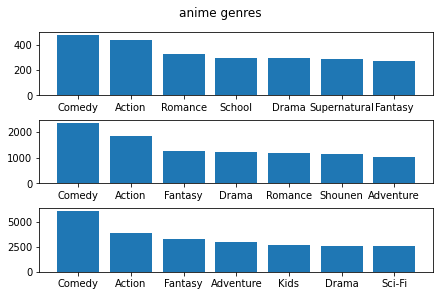

In [14]:
# getting a list of all animes, i could have used the unique function in pandas however this is just as easy
genres = []

for i in animesall["Genres"]:
    for j in i:
        genres.append(j)
        
genres = list(set(genres))

#create a dict of all of the genres and how often they occur
def encode(genre_list, genres_present):
    full = {i:0 for i in genre_list}
    for i in genres_present:
        full[i] += 1
    return full
    
# top 1000 animes
genres1k = []

for i in animes1k["Genres"]: # all of the animes in one (1d) list from a 2d one. There are flatten functions however at the time of writing this seamed easier
    for j in i:
        genres1k.append(j)

genres1k = encode(genres, genres1k)
top71k = sorted(genres1k, key=genres1k.get, reverse=True)[:7] # getting the top 7, text fit best with this

# top 5000 animes
genres5k = []

for i in animes5k["Genres"]:
    for j in i:
        genres5k.append(j)

genres5k = encode(genres, genres5k)
top75k = sorted(genres5k, key=genres5k.get, reverse=True)[:7]

# all animes
genresall = []

for i in animesall["Genres"]:
    for j in i:
        genresall.append(j)

genresall = encode(genres, genresall)
top7all = sorted(genresall, key=genresall.get, reverse=True)[:7]

# craeting the bar charts for the order of occurance
fig = plt.figure(constrained_layout=True)
f = fig.subplots(3, 1, sharey=False, squeeze=False)

plt.suptitle('anime genres')
f[0,0].bar(top71k, [genres1k[i] for i in top71k])
f[1,0].bar(top75k, [genres5k[i] for i in top75k])
f[2,0].bar(top7all, [genresall[i] for i in top7all])
plt.show()

as you can see, comedy and action are similarly distributed in all of them, however romance and school seem to be very popular, despite fewer being made overall, and conversely alot of kids anime made but it is not as common in the list of most popular. This is not to say thet there are no popular kids anime but rather not many

# age ratings

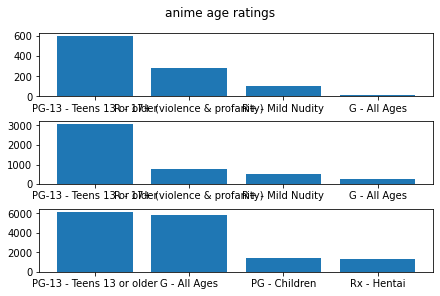

In [15]:
# similar to genres just small changes as there can only be one per show rather than a list

Rating = []

for i in animesall["Rating"]:
    Rating.append(i)
        
Rating = list(set(Rating))

def encode(rating_list, rating_present):
    full = {i:0 for i in rating_list}
    for i in rating_present:
        full[i] += 1
    return full

ratings1k = []
for i in animes1k["Rating"]:
    ratings1k.append(i)
ratings1k = encode(Rating, ratings1k)
order1k = sorted(ratings1k, key=ratings1k.get, reverse=True)[:4]

ratings5k = []
for i in animes5k["Rating"]:
    ratings5k.append(i)
ratings5k = encode(Rating, ratings5k)
order5k = sorted(ratings5k, key=ratings5k.get, reverse=True)[:4]

ratingsall = []
for i in animesall["Rating"]:
    ratingsall.append(i)
ratingsall = encode(Rating, ratingsall)
orderall = sorted(ratingsall, key=ratingsall.get, reverse=True)[:4]

fig = plt.figure(constrained_layout=True)
f = fig.subplots(3, 1, sharey=False, squeeze=False)

plt.rc('ytick', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the x and y labels


plt.suptitle('anime age ratings')
f[0,0].bar(order1k, [ratings1k[i] for i in order1k])
f[1,0].bar(order5k, [ratings5k[i] for i in order5k])
f[2,0].bar(orderall, [ratingsall[i] for i in orderall])
plt.show()

This shows that anime rated PG-13 and 17+ are more popular, despite relatively few 17+ beingmade. One theory I have is that is the age when most people watch it and it is likely heavily tied in with the popularity of action anime, which gets age ratings around there. anime rated G is made alot but is not very popular, this is likely due to the lack of violence which does seem common. The same can be said about hentai, however it is not popular likely due to age restriction as well as social stigma.

# Type - ie movie, TV etc.

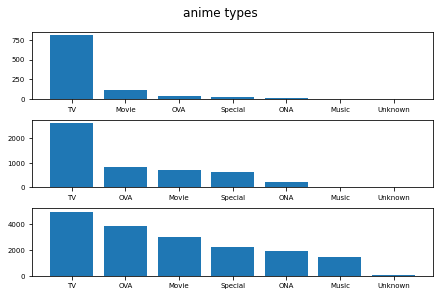

In [16]:
# similar to genres just small changes as there can only be one per show rather than a list
type = []

for i in animesall["Type"]:
    type.append(i)
        
type = list(set(type))

def encode(type_list, type_present):
    full = {i:0 for i in type_list}
    for i in type_present:
        full[i] += 1
    return full

type1k = []
for i in animes1k["Type"]:
    type1k.append(i)
type1k = encode(type, type1k)
order1k = sorted(type1k, key=type1k.get, reverse=True)[:10]

type5k = []
for i in animes5k["Type"]:
    type5k.append(i)
type5k = encode(type, type5k)
order5k = sorted(type5k, key=type5k.get, reverse=True)[:10]

typeall = []
for i in animesall["Type"]:
    typeall.append(i)
typeall = encode(type, typeall)
orderall = sorted(typeall, key=typeall.get, reverse=True)[:10]

fig = plt.figure(constrained_layout=True)
f = fig.subplots(3, 1, sharey=False, squeeze=False)

plt.rc('ytick', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the x and y labels

plt.suptitle('anime types')
f[0,0].bar(order1k, [type1k[i] for i in order1k])
f[1,0].bar(order5k, [type5k[i] for i in order5k])
f[2,0].bar(orderall, [typeall[i] for i in orderall])
plt.show()

The most commonly made seem to be the most watched with one exception. OVAs are more commonly made than watched. I have a theory as to why this is: they have lower budget than normal movies, meaning lower marketing and as a result lower exposure, as well as this the studio has likely made fewer animes previously

# source / inspiration - where did it come from

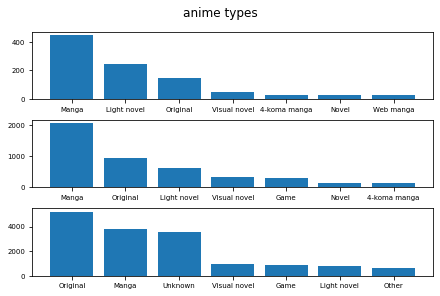

In [17]:
Source = []

for i in animesall["Source"]:
    Source.append(i)
        
Source = list(set(Source))

def encode(Source_list, Source_present):
    full = {i:0 for i in Source_list}
    for i in Source_present:
        full[i] += 1
    return full

Source1k = []
for i in animes1k["Source"]:
    Source1k.append(i)
Source1k = encode(Source, Source1k)
order1k = sorted(Source1k, key=Source1k.get, reverse=True)[:7]

Source5k = []
for i in animes5k["Source"]:
    Source5k.append(i)
Source5k = encode(Source, Source5k)
order5k = sorted(Source5k, key=Source5k.get, reverse=True)[:7]

Sourceall = []
for i in animesall["Source"]:
    Sourceall.append(i)
Sourceall = encode(Source, Sourceall)
orderall = sorted(Sourceall, key=Sourceall.get, reverse=True)[:7]

fig = plt.figure(constrained_layout=True)
f = fig.subplots(3, 1, sharey=False, squeeze=False)

plt.rc('ytick', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the x and y labels

plt.suptitle('anime types')
f[0,0].bar(order1k, [Source1k[i] for i in order1k])
f[1,0].bar(order5k, [Source5k[i] for i in order5k])
f[2,0].bar(orderall, [Sourceall[i] for i in orderall])
plt.show()

animes based on mangas seem to be the most popular, even though it is not the most commonly made, this may be due to the fact that it is already known to have a good story as well as having pre-existing popularity. The same principal can be the cause for novel based animes, and origionals are the easiest to make so they are made most (licensing / maing a novel, game etc is hard), however they are not as popular as there is no pre-existing fanbase of something original

# generator for training

In [18]:
# this is a generator that 
def ratings():
    user_current = -1
    xs = []
    ys = []
    x = [0 for i in range(len(ids))] # an array of zeros, this is 1000 long and will be filled in with ones if the referenced anime was watched
    nums = []
    for i in range(len(ratingcsv["user_id"])): # looping over the csv
        if ratingcsv["anime_id"][i] in ids: # if the anime is in the top 1000
            user = ratingcsv['user_id'][i] # what is the id of the user
            if user == user_current: # if the user is the same I will update their history
                x[id_to_num[ratingcsv['anime_id'][i]]] = 1
                nums.append(id_to_num[ratingcsv['anime_id'][i]])
            else: # if it is a new user I will yield the previous one and craete a new one
                user_current+=1
                for num in nums: # corrupt the users history, I take one out and that is the input. The target is the one that was removed
                    temp_y = [0 for i in range(len(ids))]
                    temp_x = copy.deepcopy(x) # shallow coppies do not work ):
                    
                    temp_y[num] = 1
                    temp_x[num] = 0
                                        
                    if temp_y.count(temp_y[0]) != len(temp_y) and temp_x.count(temp_x[0]) != len(temp_x):                                                                    
                        ys.append(temp_y)
                        xs.append(temp_x)
                        
                if bool(xs) == True and bool(ys) == True:
                    yield np.array([xs, ys]) # only yeild if they have seen 2 or more in the top 1000
                xs = [] # restart
                ys = []
                x = [0 for i in range(len(ids))]
                nums = []
                x[id_to_num[ratingcsv['anime_id'][i]]] = 1
                nums.append(id_to_num[ratingcsv['anime_id'][i]])

# model and training

In [19]:
model = tf.keras.Sequential([ # create a model. It is simple as to have very fast inferance time
    tf.keras.layers.Input((1000)),
    tf.keras.layers.Embedding(1000, 10),
    tf.keras.layers.Dense(32, "relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, "softmax")
])

model.compile("adam", tf.keras.losses.CategoricalCrossentropy(), metrics=["categorical_accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 10)          10000     
_________________________________________________________________
dense (Dense)                (None, 1000, 32)          352       
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              32001000  
Total params: 32,011,352
Trainable params: 32,011,352
Non-trainable params: 0
_________________________________________________________________


In [20]:
gen = ratings() 

# training, this prints the loss and accuracy every 2000 examples and logs it for plots every 250

scores = []
i = 0

for x, y in gen:
    if i % 100 == 0:
        score = model.train_on_batch(x,y)
        scores.append(score)
        if i % 2000 == 0:
            print(score)
    else:
        model.train_on_batch(x,y)
    if i == 10000: # limited to 10000 because of train time, the model uploaded was about 75000
        break
    i+=1

[6.910419940948486, 0.0]
[5.924050807952881, 0.06622516363859177]
[6.351431846618652, 0.0]
[5.916667461395264, 0.04545454680919647]
[6.42507791519165, 0.010582010261714458]
[5.622898578643799, 0.0]


over a larger number of examples the graph is a much clearer upwards trend (even reaching > 60% accuracy). The better model is in the repo

In [21]:
loss = []
acc = []

for i, j in scores:
    loss.append(i)
    acc.append(j)

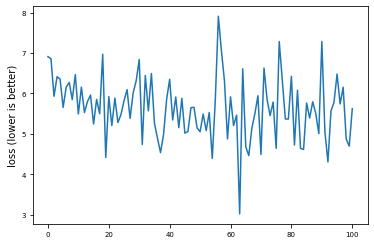

In [22]:
plt.plot(loss)
plt.ylabel('loss (lower is better)')
plt.show()

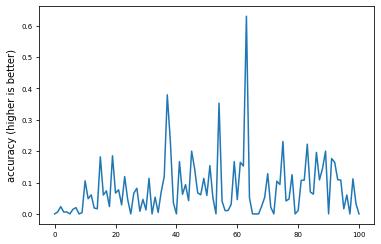

In [23]:
plt.plot(acc)
plt.ylabel('accuracy (higher is better)')
plt.show()

In [24]:
# convert to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("./")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"optimised_model.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp7c21qvto/assets
INFO:tensorflow:Assets written to: /tmp/tmpd6n1_1s3/assets


INFO:tensorflow:Assets written to: /tmp/tmpd6n1_1s3/assets


32020160

The files used come directly from [this kaggle dataset](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020)